In [28]:
import torch as tch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# device = 'cpu'
# device = 'cuda'
# batch_size=
device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

In [30]:
# input will be array in range[-1,1] 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
# should I augment the data?


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

subset_size = 500  # Choose the desired subset size
train_subset = tch.utils.data.Subset(train_dataset, range(subset_size))
test_subset = tch.utils.data.Subset(test_dataset, range(subset_size))


batch_size = 100
train_loader = tch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = tch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [31]:
n_directions = 6
direction_embedding_dimension = 32
time_embedding_dimension = 32
T = 1000
beta_1 = 10**-4
beta_T = 10**-2
beta_1_tensor = tch.tensor(beta_1)
height = 28
width = 28
# list containing \bar{alpha_t}
diffusion_scheduler = [1]
for i in range(1,T+1):
    diffusion_scheduler.append(diffusion_scheduler[i-1]*(1-i*beta_1))
print(diffusion_scheduler)
diffusion_scheduler = tch.tensor(diffusion_scheduler).to(device)

[1, 0.9999, 0.99970002, 0.9994001099940001, 0.9990003499500025, 0.9985008497750276, 0.9979017492651625, 0.9972032180406769, 0.9964054554662444, 0.9955086905563247, 0.9945131818657684, 0.9934192173657161, 0.9922271143048773, 0.990937219056281, 0.9895499069496022, 0.9880655820891778, 0.986484677157835, 0.9848076532066667, 0.9830349994308947, 0.9811672329319759, 0.979204898466112, 0.9771485681793332, 0.9749988413293387, 0.9727563439942812, 0.970421728768695, 0.9679956744467734, 0.9654788856932117, 0.96287209270184, 0.9601760508422749, 0.9573915402948322, 0.9545193656739477, 0.9515603556403585, 0.9485153625023093, 0.9453852618060516, 0.9421709519159112, 0.9388733535842055, 0.9354934095113023, 0.9320320838961105, 0.9284903619773053, 0.9248692495655938, 0.9211697725673315, 0.9173929764998054, 0.9135399259985063, 0.9096117043167128, 0.9056094128177193, 0.9015341704600397, 0.8973871132759235, 0.8931693938435266, 0.8888821807530776, 0.8845266580673875, 0.8801040247770505, 0.8756154942506875, 0.

In [32]:
# class TimeEmbedding(nn.Module):
#     def __init__(self, embed_dim: int):
#         super().__init__()
#         self.embed_dim = embed_dim

#     def forward(self, t):
#         # t: (batch_size,) - the timestep
#         # Create the sinusoidal embedding
#         half_dim = self.embed_dim // 2
#         exponents = torch.arange(half_dim, dtype=torch.float32) / half_dim
#         freqs = torch.pow(10000, -exponents).to(t.device)
#         angles = t[:, None] * freqs  # Broadcasting over the batch dimension
#         # Combine sine and cosine
#         time_embedding = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
#         return time_embedding  # Shape: (batch_size, embed_dim)


In [33]:
#define architecture and U-net
# Unet is predicting the noise.
#  I have image x. What image might I get if I denoise by time "timestep" in the past in given direction.


# for now the same as direction embedding
class TimeEmbedding(tch.nn.Module):
    def __init__(self, time_embedding_dimension):
        super().__init__()
        self.time_embedding = tch.nn.Linear(1, time_embedding_dimension)
    def forward(self, timestep):
        timestep = timestep.view(-1,1).float()
        return self.time_embedding(timestep)

class DirectionEmbedding(tch.nn.Module):
    def __init__(self, n_classes, direction_embedding_dimension):
        super().__init__()
        self.direction_embedding = tch.nn.Embedding(n_classes, direction_embedding_dimension)
    def forward(self, class_label):
         return self.direction_embedding(class_label)

# a block in my modified UNet
class Block(tch.nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dimension, direction_embedding_dimension):
        super().__init__()
        self.conv = tch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = tch.nn.BatchNorm2d(out_channels)
        self.activation = tch.nn.ReLU()
        # rescale time_embedding and direction_embedding to match the dimension of the channels
        self.time_embedding_projection = tch.nn.Linear(time_embedding_dimension, in_channels)
        self.direction_embedding_projection = tch.nn.Linear(direction_embedding_dimension, in_channels)
    def forward(self, x, time_embedding, direction_embedding):
        
        batch_size, n_channels, height, width = x.shape
        # why -1 instead of n_channels?
        #  should be broadcastable to x.
        time_embedding = self.time_embedding_projection(time_embedding).view(batch_size,-1,1,1)
        direction_embedding = self.direction_embedding_projection(direction_embedding).view(batch_size,-1,1,1)

        # adding time embedding to input
        x = x+time_embedding+direction_embedding
        
        # forward pass
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x
    


In [34]:
feature1 = 3
feature2 = 4
class modifiedUnet(tch.nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dimension, direction_embedding_dimension, n_classes):
        super().__init__()

        self.time_embedding = TimeEmbedding(time_embedding_dimension)
        self.direction_embedding = DirectionEmbedding(n_classes, direction_embedding_dimension)
        self.pool = tch.nn.MaxPool2d(kernel_size=2, stride=2)


        self.block1 = Block(in_channels, feature1, time_embedding_dimension,direction_embedding_dimension)
        # maxpool
        self.block2 = Block(feature1, feature2, time_embedding_dimension,direction_embedding_dimension)
        # maxpool
        self.block3 = Block(feature2, feature2, time_embedding_dimension,direction_embedding_dimension)
        
        # upsample
        self.up1 = tch.nn.ConvTranspose2d(feature2,feature2, kernel_size=2, stride=2)

        self.block4 = Block(feature2, feature1, time_embedding_dimension,direction_embedding_dimension)
        
        # upsample
        self.up2 = tch.nn.ConvTranspose2d(feature1,feature1, kernel_size=2, stride=2)
        
        self.block5 = Block(feature1, out_channels, time_embedding_dimension,direction_embedding_dimension)



    def forward(self, x, class_label, timestep):
        time_embedding = self.time_embedding(timestep)
        direction_embedding = self.direction_embedding(class_label)

        # no skip connections for now
        x1 = self.block1(x,time_embedding,direction_embedding)
        # downsample
        x1 = self.pool(x1)
        x2 =  self.block2(x1,time_embedding,direction_embedding)
        # downsample
        x2 = self.pool(x2)
        x3 =  self.block3(x2,time_embedding,direction_embedding)
        # upsample
        x3 = self.up1(x3)
        # skip connection below
        #  x3 = x3+x2
        x4 = self.block4(x3,time_embedding,direction_embedding)


        # upsample
        x4 = self.up2(x4)
        # skip connection below
        # x4 = x4+x1
        x5 = self.block5(x4, time_embedding, direction_embedding)
        return x5



In [35]:

# model = modifiedUnet(in_channels=1, out_channels=1, time_embedding_dimension=16, direction_embedding_dimension=16, n_classes=10)

# # Dummy inputs
# x = tch.randn(1, 1, 28, 28)  # Batch size = 1, Channels = 1, Height = 28, Width = 28
# class_label = tch.tensor([3])  # Class index for the direction embedding
# timestep = tch.tensor([5.0])  # Scalar timestep

# # Forward pass
# output = model(x, class_label, timestep)
# print(output.shape)  # Should match the shape defined by the last Block (e.g., [1, 1, 28, 28] if out_channels=1)``
# print(output)

torch.Size([1, 1, 28, 28])
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [2.0786e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [2.1865e+00, 1.5924e+00, 0.0000e+00, 6.1459e-01, 3.1850e-01,
           6.8335e-01, 3.2028e-01, 6.8130e-01, 2.3418e-01, 6.4626e-01,
           1.7764e-01, 6.

In [36]:
modifiedUnet = modifiedUnet(
    in_channels=1, 
    out_channels=1,
    time_embedding_dimension=16,
    direction_embedding_dimension=16, 
    n_classes=10).to(device)
#weights, loss function, optimizer


# Instantiate the model
# optimizer and scheduler
optimizer = tch.optim.AdamW(modifiedUnet.parameters(), lr=1e-4,
                            weight_decay=0.1)
scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=10000,
                                          gamma=0.2)
loss_func = tch.nn.MSELoss(reduction='mean')

In [37]:
a = tch.randint(low=0,high=T, size=(batch_size,))
a.shape
noise = tch.randn(batch_size, 1, height, width, device=device)

In [38]:
#training
running_loss = 0.0
epoch_loss_ = 0.0
epoch_loss = 0.0
n_epoch = 3

 
for epoch in range(n_epoch):
    i = 0
    for data in train_loader:
        ###### COMPLETER ICI ######
        loss_val = 0 # requis aux lignes suivantes
        images,labels = data
        images, labels = images.to(device), labels.to(device)
        
        timesteps = tch.randint(1, T, size=(batch_size,), device=device)  # Move timesteps to the device
        # generating a batch of random noise

        noise = tch.randn(batch_size, 1, height, width, device=device)
        alpha_bar = diffusion_scheduler[timesteps].view(-1,1,1,1).to(device)
        noised_image = tch.sqrt(alpha_bar)*images+tch.sqrt(1-alpha_bar)*noise
        predicted_noise = modifiedUnet(noised_image,labels, timesteps)
        loss_val = loss_func(noise, predicted_noise)
        ## Gradient calculation
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        #####

        running_loss += loss_val.item()
        epoch_loss += loss_val.item()
        print(f"Epoch = {epoch}", end="\r", flush=True)
    if epoch % 10 == 0:    # every 100 epoch...
        # disp_loss(epoch_loss, epoch)
        pass
    i = i+1
    epoch_loss = 0.0
    scheduler.step()  

#save the model weights after training
tch.save(modifiedUnet.state_dict(), 'model_weights.pth')


torch.Size([100, 1, 28, 28])
tensor([[[[ 0.2843, -0.1254,  0.3258,  ...,  0.4570, -0.1362, -0.1375],
          [ 0.2731, -0.0479, -0.3370,  ...,  0.2387,  0.4787,  0.2098],
          [ 0.3362, -0.2064, -0.2961,  ..., -0.0840, -0.0472, -0.2859],
          ...,
          [-0.3799,  0.2064, -0.0335,  ..., -0.2411, -0.2498, -0.1472],
          [ 0.3017,  0.2287,  0.1740,  ..., -0.1616, -0.1287,  0.6310],
          [-0.3150,  0.3799,  0.3195,  ...,  0.0925, -0.0479,  0.1493]]],


        [[[-0.3271,  0.2176,  0.0902,  ..., -0.2250,  0.2685, -0.4917],
          [-0.6474,  0.1665, -0.4795,  ..., -0.0912,  0.4784,  0.4119],
          [ 0.2659,  0.2122,  0.3020,  ..., -0.3189, -0.2113, -0.3505],
          ...,
          [-0.0154, -0.2211,  0.2403,  ...,  0.1412, -0.2264, -0.1517],
          [ 0.3163,  0.2225,  0.0846,  ...,  0.0016,  0.1408,  0.0258],
          [-0.0987,  0.2383, -0.0798,  ..., -0.1580, -0.0022, -0.2956]]],


        [[[ 0.4175,  0.3033,  0.2268,  ..., -0.3193, -0.2854, -0.0948

/tmp/ipykernel_36736/3455503051.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = tch.tensor(labels)


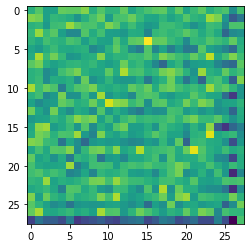

In [59]:
def normalize_data(images):
    # for each image take a maximu of absolute values. Look at channels, height and width
    # thus each image gets scaled individually
    max_vals = tch.amax(tch.abs(images), dim=(1, 2, 3), keepdim=True)
    # images are between [0,1]
    images = images/max_vals
    return images
# how to generate image from noise
# algorith from DDPM paper
def generate_image(n_images,labels, noise_predictor):
    noise_predictor = noise_predictor.cpu()
    labels = tch.tensor(labels)
    images = tch.randn(n_images,1,height,width)
    # normalize images
    images = normalize_data(images)
    i = T
    while(i>0):
        times = tch.tensor([i] * n_images)
        alpha_bar = diffusion_scheduler[i]
        # sigma_t * z term 
        if i>1:
            noise = tch.sqrt(i*beta_1_tensor)*tch.randn(n_images,1, height, width)
        else:
            noise = images*0
        # i*beta = 1-alphta_t = beta_t
        images = (1/tch.sqrt(alpha_bar))*(images-i*beta_1_tensor/tch.sqrt(1-alpha_bar)*noise_predictor(images,labels,times)) +noise 
        images = normalize_data(images)
        i = i-1
    return images.detach().numpy()
    # return images.detach().numpy().squeeze(1)

img = generate_image(1, tch.tensor([1]),modifiedUnet).detach().numpy().squeeze(0)
plt.imshow(img[0])